In [57]:
import os
import shutil
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from numpy import deg2rad
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit


In [35]:
def load_data(ratname, file_path):
    # Load the .mat file
    with h5py.File(file_path, 'r') as f:
        # List all keys
        keys = list(f.keys())
        #print(f"Keys: {keys}")

        # Access the sdata structure
        sdata = f['sdata']

        # Check if 'light1' exists in sdata
        if 'light1' not in sdata:
            print(f"'light1' not found in {file_path}")
            return None

        # Accessing the light1 group and its datasets
        light1 = sdata['light1']
        ppox = np.array(light1['pox'])
        ppoy = np.array(light1['poy'])
        pot = np.array(light1['pot'])
        poh = np.array(light1['poh'])
        pov = np.array(light1['pov'])
        f0 = np.array(light1['F0'])
        sintcptFreqy = np.array(light1['sintcptFreqy'])

        # Extract all cells containing the name 'R222'
        cell_names = [key for key in sdata.keys() if ratname in key]
        #print(f"Cell Names: {cell_names}")

        # Initialize dictionary to store data for all cells
        cells_data = {}

        # Iterate over each cell name and extract data
        for cell_name in cell_names:
            part_now = 'light1'  # Assuming 'light1' is the part_now equivalent

            pspx = np.array(sdata[cell_name][part_now]['spx'])
            pspy = np.array(sdata[cell_name][part_now]['spy'])
            pspt = np.array(sdata[cell_name][part_now]['spt'])
            pspv = np.array(sdata[cell_name][part_now]['spv'])
            psph = np.array(sdata[cell_name][part_now]['sph'])
            pspm = np.array(sdata[cell_name][part_now]['spm'])
            pval = np.array(sdata[cell_name][part_now]['pval'])
            spike_phase = np.array(sdata[cell_name][part_now]['spike_phase'])
            autocorrelogram = np.array(sdata[cell_name][part_now]['theta_train_long2'])
            hd_mean = np.array(sdata[cell_name][part_now]['hd_mean'])
            hd_std = np.array(sdata[cell_name][part_now]['hd_stdev'])
            tune_width = np.array(sdata[cell_name][part_now]['tuning_width'])
            intrinsic_freq = np.array(sdata[cell_name][part_now]['intrinsic_theta_frequency'])

            # Extract and decode cell_type
            cell_type_array = np.array(sdata[cell_name][part_now]['thetacell_type'])
            cell_type = ''.join([chr(ascii_val[0]) for ascii_val in cell_type_array])

            # Store the data for this cell
            cells_data[cell_name] = {
                'pspx': pspx,
                'pspy': pspy,
                'pspt': pspt,
                'pspv': pspv,
                'psph': psph,
                'pspm': pspm,
                'pval': pval,
                'spike_phase': spike_phase,
                'autocorrelogram': autocorrelogram,
                'hd_mean': hd_mean,
                'hd_std': hd_std,
                'tune_width': tune_width,
                'intrinsic_freq': intrinsic_freq,
                'cell_type': cell_type
            }

        # Create a dictionary to store all the data
        data_dict = {
            'ppox': ppox,
            'ppoy': ppoy,
            'pot': pot,
            'poh': poh,
            'pov': pov,
            'f0': f0,
            'sintcptFreqy': sintcptFreqy,
            'cell_names': cell_names,
            'cells_data': cells_data
        }

        return data_dict



In [98]:
def calculate_angular_speed(poh, pot, sigma=5):
    """
    Calculate the head rotation speed (angular speed) from head direction and time data.

    Parameters:
    poh : np.array
        Array of head direction angles in degrees.
    pot : np.array
        Array of time points corresponding to the head direction angles.
    sigma : float
        Standard deviation for Gaussian kernel used in smoothing.

    Returns:
    angular_speed : np.array
        Array of angular speed values.
    """

    # Ensure head direction angles are in radians
    poh_rad = np.deg2rad(poh)

    # Convert angles to complex exponential form
    poh_complex = np.exp(1j * poh_rad)

    # Apply Gaussian smoothing to real and imaginary parts separately
    poh_smooth_real = gaussian_filter1d(poh_complex.real, sigma=sigma)
    poh_smooth_imag = gaussian_filter1d(poh_complex.imag, sigma=sigma)

    # Convert back to angles
    poh_smooth = np.angle(poh_smooth_real + 1j * poh_smooth_imag)

    # Calculate the time differences
    dt = np.diff(pot)

    # Calculate the angle differences
    dtheta = np.diff(poh_smooth)
    
    #deal with the jump between 0 and 2pi
    dtheta[dtheta > np.pi] -= 2 * np.pi
    dtheta[dtheta < -np.pi] += 2 * np.pi
    
    # Calculate the angular speed
    angular_speed = dtheta / dt
    
    angular_speed = angular_speed.flatten()

    #add one element to the beginning of angular_speed to make it the same length as poh
    angular_speed = np.insert(angular_speed, 0, angular_speed[0])

    return angular_speed

def get_angular_speed_at_spikes(pspt, pot, angular_speed):

    angular_speed_spike = []
    for spike_time in pspt:
        # Find the index of the closest time in pot
        index = np.argmin(np.abs(pot - spike_time))
        angular_speed_spike.append(angular_speed[index])
    
    return np.array(angular_speed_spike)

def find_continuous_periods(angular_speed, pot, speed_threshold=0.5, duration_threshold=1.0):
    if speed_threshold > 0:
        # Identify where angular speed exceeds the threshold
        above_threshold = angular_speed > speed_threshold
    elif speed_threshold < 0:
        # Identify where angular speed is below the threshold
        above_threshold = angular_speed < speed_threshold
    else:
        raise ValueError("Speed threshold must be non-zero")

    # Find the indices where the state changes
    change_indices = np.diff(above_threshold.astype(int), prepend=0, append=0)

    # Identify the start and end indices of the segments
    start_indices = np.where(change_indices == 1)[0]
    end_indices = np.where(change_indices == -1)[0]

    # Ensure there is a matching number of start and end indices
    if len(start_indices) > len(end_indices):
        end_indices = np.append(end_indices, len(angular_speed) - 1)
    elif len(end_indices) > len(start_indices):
        start_indices = np.insert(start_indices, 0, 0)

    continuous_periods = []
    for start, end in zip(start_indices, end_indices):
        if end >= len(pot):
            end = len(pot) - 1
        duration = pot[end] - pot[start]
        if duration >= duration_threshold:
            continuous_periods.append((pot[start], pot[end]))

    return continuous_periods

def compute_spike_array(spike_times, timestamps):
    """
    Compute the spike array from spike times and timestamps.
    """
    
    # Assume t is sorted. If not, you must sort it first.
    indices = np.searchsorted(timestamps, spike_times, side='right')

    # Ensure no out-of-bounds indices
    indices = np.clip(indices, 0, len(timestamps) - 1)

    # Adjust indices to always refer to the nearest timestamp
    # If the index points to the start of the array, no need to adjust
    # If not, check if the previous index is closer
    prev_close = (indices > 0) & (np.abs(timestamps[indices - 1] - spike_times) < np.abs(timestamps[indices] - spike_times))
    indices[prev_close] -= 1

    spike_array = np.zeros_like(timestamps)
    np.add.at(spike_array, indices, 1) #very fast!
    
    return spike_array

def calculate_intrinsic_frequency(autocorrelogram):
    def model(t, a, b, c, omega, t1, t2):
        return (a * (np.sin(2*np.pi*omega * t) + 1) + b) * np.exp(-np.abs(t) / t1) + c * np.exp(-t**2 / t2**2)
    
    # Fit the model to the autocorrelogram data
    initial_guess = [1, 0.1, 0.1, 8, 0.01, 0.01]  # Initial guesses for a, b, c, omega, t1, t2
    bounds = ([0, 0, 0, 6, 0, 0], [np.inf, np.inf, 0.8, 12, 0.05, 0.05])  # Bounds for the parameters

    autocorr = autocorrelogram[0, :]
    lags = autocorrelogram[1, :] / 1000  # Convert lags to seconds

    params, covariance = curve_fit(model, lags, autocorr, p0=initial_guess, bounds=bounds)
    # Extract the intrinsic frequency (omega)
    intrinsic_frequency = params[3]
    print(f"Intrinsic Theta Frequency: {intrinsic_frequency:.2f} Hz")
    
    return intrinsic_frequency  

def compute_autocorrelation(spike_array, bin_size=0.02, max_lag=0.5):
    # Number of bins for the max_lag
    max_lag_bins = int(max_lag / bin_size)
    autocorr = np.correlate(spike_array, spike_array, mode='full')
    mid_point = len(autocorr) // 2
    autocorr = autocorr[mid_point - max_lag_bins: mid_point + max_lag_bins + 1]
    
    # Normalize the autocorrelation values
    lags = np.arange(-max_lag_bins, max_lag_bins + 1) * bin_size  # Lags in seconds
    
    idx_range = np.where((lags >= 0.05) & (lags <= 0.15))[0]
    max_value = np.max(autocorr[idx_range])
    autocorr = autocorr / max_value
    autocorr = np.clip(autocorr, a_min=None, a_max=1)  # Clip values above 1
    
    lags_ms = lags * 1000  # Convert to ms
    
    # Convert autocorr, lags into a 2*n array
    return np.array([autocorr, lags_ms])

def get_autocorrelogram_move_still(ppoh, pot, pspt, config):

    speed_threshold = config['speed_threshold']
    duration_threshold = config['duration_threshold']
    speed_smooth_sigma = config['speed_smooth_sigma']

    #calculate angular speed
    angular_speed = calculate_angular_speed(ppoh, pot, sigma=speed_smooth_sigma)

    continuous_periods_CCW = find_continuous_periods(angular_speed, pot, speed_threshold=-speed_threshold, duration_threshold=duration_threshold)
    continuous_periods_CW = find_continuous_periods(angular_speed, pot, speed_threshold=speed_threshold, duration_threshold=duration_threshold)

    pspt_move = []
    for i in range(len(continuous_periods_CCW)):
        #keet pspt if it is in the continuous period
        pspt_move.extend(pspt[(pspt >= continuous_periods_CCW[i][0]) & (pspt <= continuous_periods_CCW[i][1])])
    for i in range(len(continuous_periods_CW)):
        #keet pspt if it is in the continuous period
        pspt_move.extend(pspt[(pspt >= continuous_periods_CW[i][0]) & (pspt <= continuous_periods_CW[i][1])])    

    #sort
    pspt_move = np.sort(pspt_move)

    spike_array = compute_spike_array(pspt_move, pot)
    autocorrelogram_move = compute_autocorrelation(spike_array, bin_size=0.02, max_lag=0.5) 

    #get remaining spike time
    pspt_rest = np.setdiff1d(pspt, pspt_move)
    spike_array = compute_spike_array(pspt_rest, pot)
    autocorrelogram_still = compute_autocorrelation(spike_array, bin_size=0.02, max_lag=0.5)

    return autocorrelogram_move, autocorrelogram_still

In [31]:
def plot_head_direction_tuning(ax, ppoh, psph, pval, hd_mean, hd_std, tune_width, cell_name, config, pos_tb=0.02):
    """
    Plot the head direction tuning map in a polar plot.

    Parameters:
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        The polar axes to plot on.
    ppoh : np.array
        Array of session head direction angles in degrees.
    psph : np.array
        Array of cell head direction angles in degrees.
    pos_tb : float
        Time base for converting session HD to time.
    cell_name : str
        Name of the cell for which the tuning map is plotted.
    config : dict
        Configuration dictionary containing 'hd_bins' and 'hd_boxcar' parameters.
    """

    # Convert angles to radians
    ppoh_rad = deg2rad(ppoh)
    psph_rad = deg2rad(psph)

    # Calculate histograms for session and cell head directions
    hd1, _ = np.histogram(ppoh_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))
    hd2, _ = np.histogram(psph_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))

    # Boxcar filter
    boxcar_size = config['hd_boxcar']
    boxcar_filter = np.ones(boxcar_size) / boxcar_size

    # Apply boxcar filter
    hd1_filtered = convolve1d(hd1, boxcar_filter, mode='wrap')
    hd2_filtered = convolve1d(hd2, boxcar_filter, mode='wrap')

    # Convert session HD to time (i.e., dwelling time in each HD bin)
    hd1_time = hd1_filtered * pos_tb

    # Calculate HD firing rate
    hd3 = hd2_filtered / hd1_time

    # Normalize session HD
    hd1_normalized = hd1_time / np.max(hd1_time)

    # Normalize cell HD firing rate
    hd3_normalized = hd3 / np.max(hd3)
    hd3_normalized = hd3_normalized.flatten()

    # Close the loop by appending the first element to the end
    theta = np.linspace(0, 2 * np.pi, config['hd_bins'], endpoint=False)
    theta = np.append(theta, theta[0])
    hd1_normalized = np.append(hd1_normalized, hd1_normalized[0])
    hd3_normalized = np.append(hd3_normalized, hd3_normalized[0])

    # Plot the session head direction with shading
    ax.plot(theta, hd1_normalized, label='Session Head Direction', color='gray')
    ax.fill_between(theta, 0, hd1_normalized, facecolor='gray', alpha=0.2)

    # Plot the cell head direction firing rate
    ax.plot(theta, hd3_normalized, label='Cell Head Direction Firing Rate', color='#38c7ff')
    ax.fill_between(theta, 0, hd3_normalized, facecolor='#38c7ff', alpha=0.5)

    #ax.set_title(cell_name + '\n'+str(np.round(hd_mean,1))+'('+str(np.round(hd_std,1))+')' +'\nRayleigh_p=' + str(np.round(pval, 4)), fontsize=10)
    
    ax.set_title(f"{cell_name}\nAngle:{hd_mean:.0f} ({hd_std:.0f})\nTuning width:{tune_width:.0f}\nRayleigh_p={pval:.4f}", fontsize=10)
    # ax.legend()

    return ax

def plot_autocorrelogram(ax, autocorrelogram, cell_type):
    
    ax.plot(autocorrelogram[1,:], autocorrelogram[0,:], 'k')
    #fillin between y=0 and autocorrelogram
    ax.fill_between(autocorrelogram[1,:], 0, autocorrelogram[0,:], facecolor='black')
    ax.set_xticks([-500, 0, 500])
    ax.set_yticks([])
    ax.set_xlabel('Lag (ms)')
    ax.set_title(cell_type)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return ax



## plot example recording session

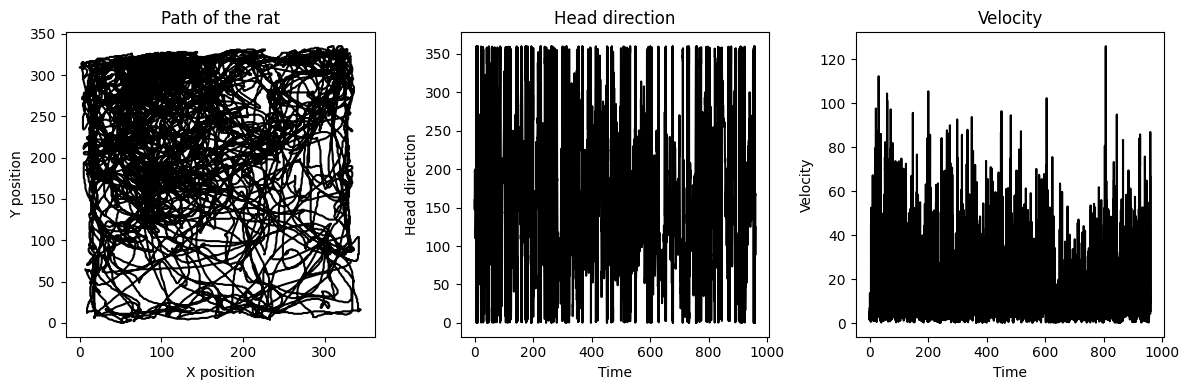

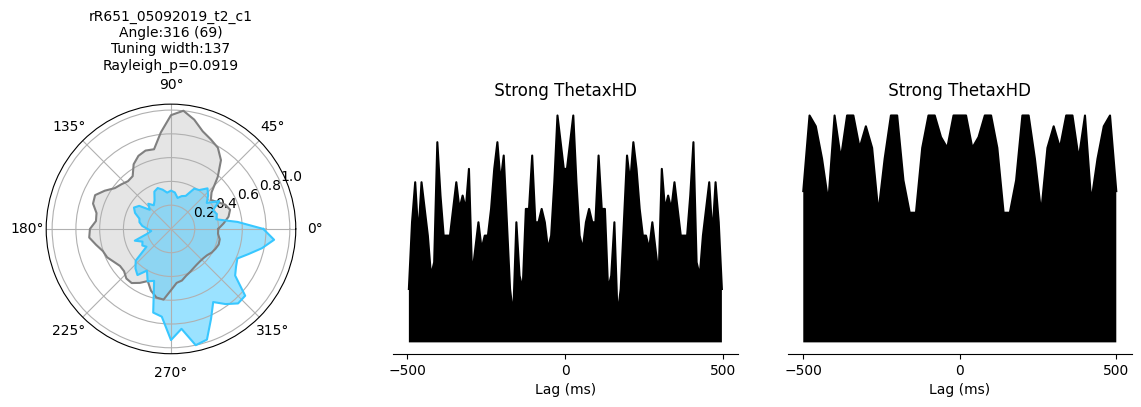

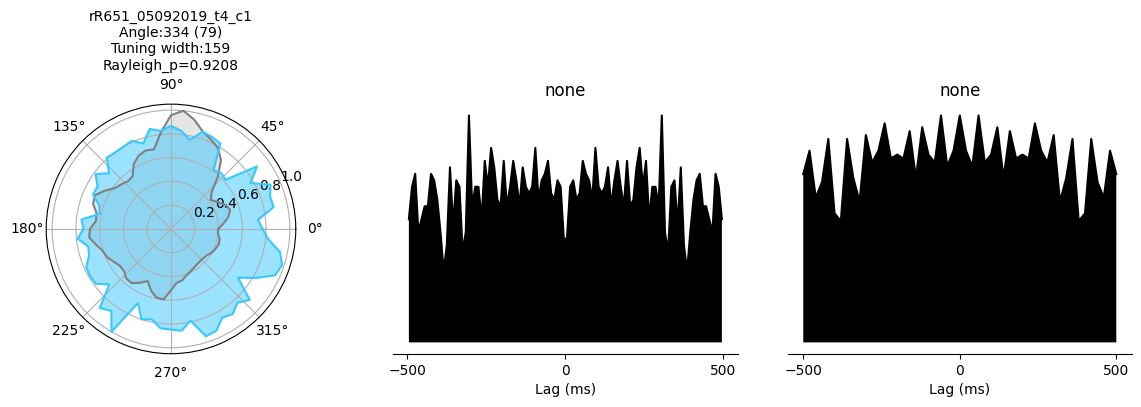

In [52]:
ratname = 'R651'
file_path = '/home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r651/R651_050919_T1_sdata.mat'
data_dict = load_data(ratname, file_path)

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.1,
    'duration_threshold': 1,
    'speed_smooth_sigma': 10
}
all_f0 = []
all_sintcptFreqy = []

if data_dict is not None:
    ppox = data_dict['ppox']
    ppoy = data_dict['ppoy']
    pot = data_dict['pot'].flatten()
    pov = data_dict['pov']
    poh = data_dict['poh'] 
    f0 = data_dict['f0']
    sintcptFreqy = data_dict['sintcptFreqy']
    
    all_f0.append(f0)
    all_sintcptFreqy.append(sintcptFreqy)
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    ax = axs[0]
    ppox = ppox.astype(float).flatten()
    ppoy = ppoy.astype(float).flatten()
    ax.plot(ppox, ppoy, 'k')
    ax.set_title('Path of the rat')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')

    ax = axs[1]
    ax.plot(pot.flatten(), poh.flatten(), 'k')
    ax.set_title('Head direction')
    ax.set_xlabel('Time')
    ax.set_ylabel('Head direction')

    ax = axs[2]
    ax.plot(pot.flatten(), pov.flatten(), 'k')
    ax.set_title('Velocity')
    ax.set_xlabel('Time')
    ax.set_ylabel('Velocity')

    plt.tight_layout()   
    
    for cell_name, cell_data in data_dict['cells_data'].items():
        
        fig2 = plt.figure(figsize=(12, 4))
        gs=fig2.add_gridspec(1, 3)

        psph = cell_data['psph'].flatten()
        pspt = cell_data['pspt'].flatten()
        spike_phase = cell_data['spike_phase'].flatten()
        pval = cell_data['pval'][0][0]
        hd_mean = cell_data['hd_mean'][0][0]
        hd_std = cell_data['hd_std'][0][0]
        tune_width = cell_data['tune_width'][0][0]
        autocorrelogram = cell_data['autocorrelogram']
        cell_type = cell_data['cell_type']
        
        
        ax0 = fig2.add_subplot(gs[0, 0], projection='polar')
        
        plot_head_direction_tuning(ax0, poh, psph, pval, hd_mean, hd_std, tune_width, cell_name, config)
        
        ax1 = fig2.add_subplot(gs[0, 1])

        plot_autocorrelogram(ax1, autocorrelogram, cell_type)
        
        ax2 = fig2.add_subplot(gs[0, 2])
        #calculate autocorrelation of spike in [-500, 500] ms, each bin is 20 ms
        spike_array = compute_spike_array(pspt, pot)
        autocorrelogram2 = compute_autocorrelation(spike_array, bin_size=0.02, max_lag=0.5)
        plot_autocorrelogram(ax2, autocorrelogram2, cell_type)
        
        plt.tight_layout()    



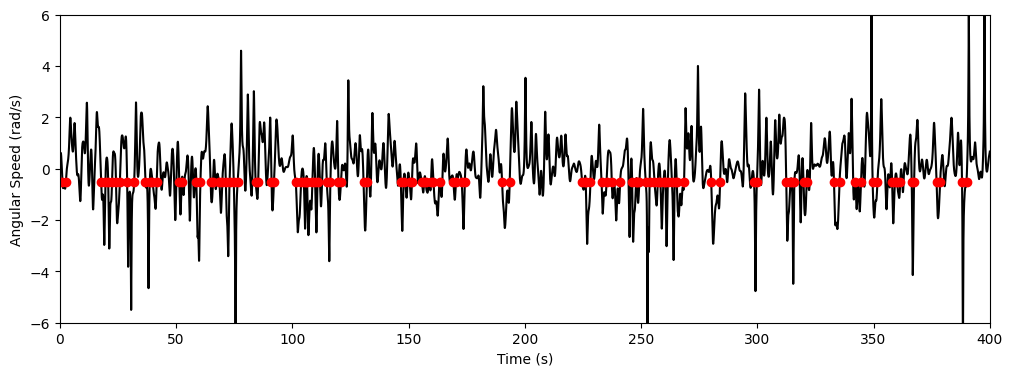

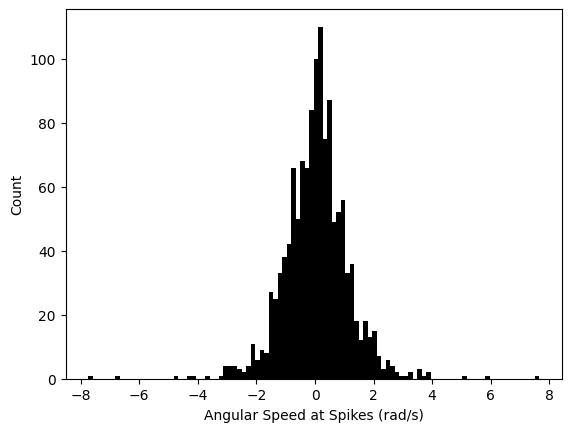

In [53]:
angular_speed = calculate_angular_speed(poh, pot, sigma=20)

speed_threshold = -0.5
duration_threshold = 1
#find the continuous periods where the angular speed is above 0.5 rad/s
continuous_periods = find_continuous_periods(angular_speed, pot, speed_threshold=speed_threshold, duration_threshold=duration_threshold)

#plot the angular speed vs time and mark continuous periods as red dots
plt.figure(figsize=(12, 4))
plt.plot(pot, angular_speed, 'k')
for start, end in continuous_periods:
    plt.plot([start, end], [speed_threshold, speed_threshold], 'ro-')
plt.xlabel('Time (s)')
plt.ylabel('Angular Speed (rad/s)')
plt.xlim(0,400)
plt.ylim(-6, 6)


# print(angular_speed.shape)
# #plot the histgoram of angular speed
# plt.hist(angular_speed, bins=100, color='black')
# plt.xlabel('Angular Speed (rad/s)')
# plt.ylabel('Count')

#get the angular speed when the spike occurs using the spike time: pspt
angular_speed_at_spikes = get_angular_speed_at_spikes(pspt, pot, angular_speed)

#plot the histogram of angular speed at spikes
plt.figure()
plt.hist(angular_speed_at_spikes, bins=100, color='black')
plt.xlabel('Angular Speed at Spikes (rad/s)')
plt.ylabel('Count')
plt.show()

## save of directional tuning map from all head direction cells

In [116]:
base_dir = '/home/zilong/Desktop/GridCellThetaSweeps/LomiData/'
output_dir = '/home/zilong/Desktop/GridCellThetaSweeps/figures/autocorr/'
output_skip_dir = '/home/zilong/Desktop/GridCellThetaSweeps/figures/autocorr_skip/'
output_nonskip_dir = '/home/zilong/Desktop/GridCellThetaSweeps/figures/autocorr_nonskip/'

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.5,
    'duration_threshold': 0.5,
    'speed_smooth_sigma': 2, 
}

# Create output directory if it doesn't exist
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)    
os.makedirs(output_dir)

# Create output directory if it doesn't exist
if os.path.exists(output_skip_dir):
    shutil.rmtree(output_skip_dir)    
os.makedirs(output_skip_dir)

# Create output directory if it doesn't exist
if os.path.exists(output_nonskip_dir):
    shutil.rmtree(output_nonskip_dir)    
os.makedirs(output_nonskip_dir)

total_hd_cells = 0

psph_CW_all = []
spike_phase_CW_all = [] 
psph_CCW_all = [] 
spike_phase_CCW_all = []
all_f0 = []
all_sintcptFreqy = []
all_intrinsic_freq = []
all_intrinsic_freq2 = []
all_intrinsic_freq3 = []
all_intrinsic_freq_move = []
all_intrinsic_freq_still = []

all_f0_skipping = []
all_intrinsic_freq_paper_skipping = []
all_sintcptFreqy_skipping = []
all_intrinsic_freq_move_skipping = []
all_intrinsic_freq_still_skipping = []

all_f0_nonskipping = []
all_intrinsic_freq_paper_nonskipping = []
all_sintcptFreqy_nonskipping = []
all_intrinsic_freq_move_nonskipping = []
all_intrinsic_freq_still_nonskipping = []
# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    
                    f0 = data_dict['f0']
                    sintcptFreqy = data_dict['sintcptFreqy']
                    
                    all_f0.append(f0)
                    all_sintcptFreqy.append(sintcptFreqy)
                    
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        psph = cell_data['psph'].flatten()
                        pspt = cell_data['pspt'].flatten()
                        spike_phase = cell_data['spike_phase'].flatten()
                        pval = cell_data['pval'][0][0]
                        hd_mean = cell_data['hd_mean'][0][0]
                        hd_std = cell_data['hd_std'][0][0]
                        tune_width = cell_data['tune_width'][0][0]
                        autocorrelogram = cell_data['autocorrelogram']
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        cell_type = cell_data['cell_type']
                        
                        if pval < 0.05: #select only head direction tuned cells
                            

                            #plot
                            fig = plt.figure(figsize=(8, 4))
                            gs=fig.add_gridspec(1, 3)
                            
                            #plot head direction tuning map
                            ax0 = fig.add_subplot(gs[0, 0], projection='polar')
                            ax0 = plot_head_direction_tuning(ax0, ppoh, psph, pval, hd_mean, hd_std, tune_width, cell_name, config)
                            
                            #plot autocorrelogram, i.e., check theta modulation
                            ax1 = fig.add_subplot(gs[0, 1])
                            autocorrelogram = cell_data['autocorrelogram']
                            ax1 = plot_autocorrelogram(ax1, autocorrelogram, cell_type)
                            
                            #plot spike phase versus head direction, i.e., check phase precession
                            ax2 = fig.add_subplot(gs[0, 2])
                            spike_array = compute_spike_array(pspt, pot)
                            autocorrelogram2 = compute_autocorrelation(spike_array, bin_size=0.02, max_lag=0.5)                   
                            ax2 = plot_autocorrelogram(ax2, autocorrelogram2, cell_type)
                            
                            output_path = os.path.join(output_dir, f"{cell_name}.png")
                            plt.tight_layout()
                            plt.savefig(output_path)
                            
                            #save fig according to cell type in different folders
                            if 'ThetaxHD' in cell_type:
                                init_freq2 = calculate_intrinsic_frequency(autocorrelogram)
                                all_intrinsic_freq2.append(init_freq2)
                                all_intrinsic_freq.append(intrinsic_freq)
                                
                                init_freq3 = calculate_intrinsic_frequency(autocorrelogram2)
                                all_intrinsic_freq3.append(init_freq3)  
                                
                                #compute autocorrelogram_move and autocorrelogram_still
                                autocorrelogram_move, autocorrelogram_still = get_autocorrelogram_move_still(ppoh, pot, pspt, config)      
                                init_freq_move = calculate_intrinsic_frequency(autocorrelogram_move)
                                all_intrinsic_freq_move.append(init_freq_move)   
                                                               
                                init_freq_still = calculate_intrinsic_frequency(autocorrelogram_still)
                                all_intrinsic_freq_still.append(init_freq_still)  
                                                                
                                if 'skip'in cell_type:
                                    all_f0_skipping.append(f0)
                                    all_sintcptFreqy_skipping.append(sintcptFreqy)
                                    all_intrinsic_freq_paper_skipping.append(intrinsic_freq)
                                    all_intrinsic_freq_move_skipping.append(init_freq_move)
                                    all_intrinsic_freq_still_skipping.append(init_freq_still)
                                    output_skip_path = os.path.join(output_skip_dir, f"{cell_name}.png")
                                    plt.savefig(output_skip_path)
                                else:
                                    all_f0_nonskipping.append(f0)
                                    all_sintcptFreqy_nonskipping.append(sintcptFreqy)
                                    all_intrinsic_freq_paper_nonskipping.append(intrinsic_freq)
                                    all_intrinsic_freq_move_nonskipping.append(init_freq_move)
                                    all_intrinsic_freq_still_nonskipping.append(init_freq_still)
                                    output_nonskip_path = os.path.join(output_nonskip_dir, f"{cell_name}.png")
                                    plt.savefig(output_nonskip_path)
                                
                                
                            plt.close(fig)
                            
                            total_hd_cells += 1
                        
print(f"Total number of HD cells processed: {total_hd_cells}")

print("All plots have been saved.")

Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_100919_T1_sdata.mat
Intrinsic Theta Frequency: 8.26 Hz
Intrinsic Theta Frequency: 8.39 Hz
Intrinsic Theta Frequency: 7.13 Hz
Intrinsic Theta Frequency: 8.24 Hz
Intrinsic Theta Frequency: 11.95 Hz
Intrinsic Theta Frequency: 7.59 Hz
Intrinsic Theta Frequency: 6.84 Hz
Intrinsic Theta Frequency: 12.00 Hz
Intrinsic Theta Frequency: 12.00 Hz
Intrinsic Theta Frequency: 9.29 Hz
Intrinsic Theta Frequency: 11.80 Hz
Intrinsic Theta Frequency: 10.38 Hz
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_250719_T1_sdata.mat
Processing /home/zilong/Desktop/GridCellThetaSweeps/LomiData/DATA r652/R652_090819_T

In [105]:
print(np.mean(f0), np.mean(all_sintcptFreqy), np.nanmean(all_intrinsic_freq), np.mean(all_intrinsic_freq2), np.mean(all_intrinsic_freq3))

8.747039280011181 8.430424953391755 8.940648665388009 8.425587345494064 9.152550069131498


In [117]:
print(np.mean(all_intrinsic_freq_move), np.mean(all_intrinsic_freq_still))
print(np.mean(all_f0_skipping), np.mean(all_sintcptFreqy_skipping), np.mean(all_intrinsic_freq_paper_skipping), np.mean(all_intrinsic_freq_move_skipping), np.mean(all_intrinsic_freq_still_skipping))
print(np.mean(all_f0_nonskipping), np.mean(all_sintcptFreqy_nonskipping), np.mean(all_intrinsic_freq_paper_nonskipping),  np.mean(all_intrinsic_freq_move_nonskipping), np.mean(all_intrinsic_freq_still_nonskipping))

9.282796256378596 9.270819477897465
9.012205120856764 8.421152136791722 8.916489851269722 9.447069104401555 9.427601871928067
8.922209334946059 8.433096704498656 8.95006119036916 9.218793848057963 9.209735428275152


In [120]:
#t test between all_intrinsic_freq_move_skipping and all_intrinsic_freq_still_skipping
from scipy.stats import ttest_ind
tstat, pval = ttest_ind(all_intrinsic_freq_move_skipping, all_intrinsic_freq_still_skipping)
print(pval)
all_intrinsic_freq_move_skipping

0.975928257906935


[6.4166299494377315,
 8.164935017962812,
 11.991181558682474,
 6.917932561896119,
 7.484433438055243,
 6.003043828330859,
 6.000035967553783,
 11.999998455336133,
 11.999879539993815,
 11.999963433230088,
 11.605626087664602,
 6.030248052602138,
 9.924057552261036,
 6.0164247877609505,
 11.731092552653122,
 11.99987805054661,
 7.212771535691679,
 7.857957352400204,
 10.630748151453039,
 8.592100573408299,
 11.998968621819396,
 11.910628713174619,
 6.002913119539592,
 11.999999993691796,
 7.194145274982044,
 11.999847224772962,
 11.999983262757524,
 11.717180289172266,
 7.514804373754505,
 10.494663811461244]

<Axes: title={'center': 'xxx'}, xlabel='Lag (ms)'>

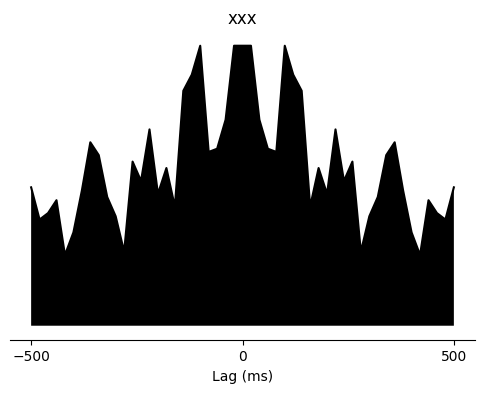

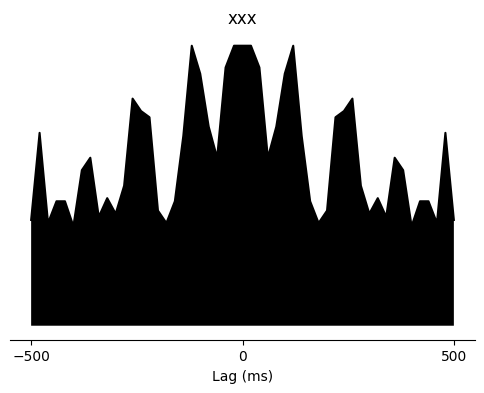

In [97]:



autocorrelogram_move, autocorrelogram_still = get_autocorrelogram_move_still(ppoh, pot, pspt, config)

#plor autocorrelogram
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_autocorrelogram(ax, autocorrelogram_move, 'xxx')  

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_autocorrelogram(ax, autocorrelogram_still, 'xxx')



(691,)